
=== Rolling Day 2024-12-01 ===
  train_cutoff=2024-07-01  val_cutoff=2024-11-30
  Forecast next 30 days from 2024-12-01 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-01_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-01_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-01_V1.pt
[PyTorch] Loading CNN from ./best_CNN_2024-12-01_V1.pt
[PyTorch] Loading Transformer from ./best_Transformer_2024-12-01_V1.pt
[PyTorch] Loading N-BEATS from ./best_N-BEATS_2024-12-01_V1.pt
[PyTorch] Loading N-HITS from ./best_N-HITS_2024-12-01_V1.pt
[sklearn] Loading SVM => ./best_SVM_2024-12-01_V1.pkl
[sklearn] Loading Boost => ./best_Boost_2024-12-01_V1.pkl

=== Rolling Day 2024-12-02 ===
  train_cutoff=2024-07-02  val_cutoff=2024-12-01
  Forecast next 30 days from 2024-12-02 w/ noise => more volatility
[PyTorch] Loading LSTM from ./best_LSTM_2024-12-02_V1.pt
[PyTorch] Loading GRU from ./best_GRU_2024-12-02_V1.pt
[PyTorch] Loading RNN from ./best_RNN_2024-12-02_V1.pt
[PyTor

/tmp/ipykernel_781216/375182111.py:388: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
/tmp/ipykernel_781216/375182111.py:407: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()


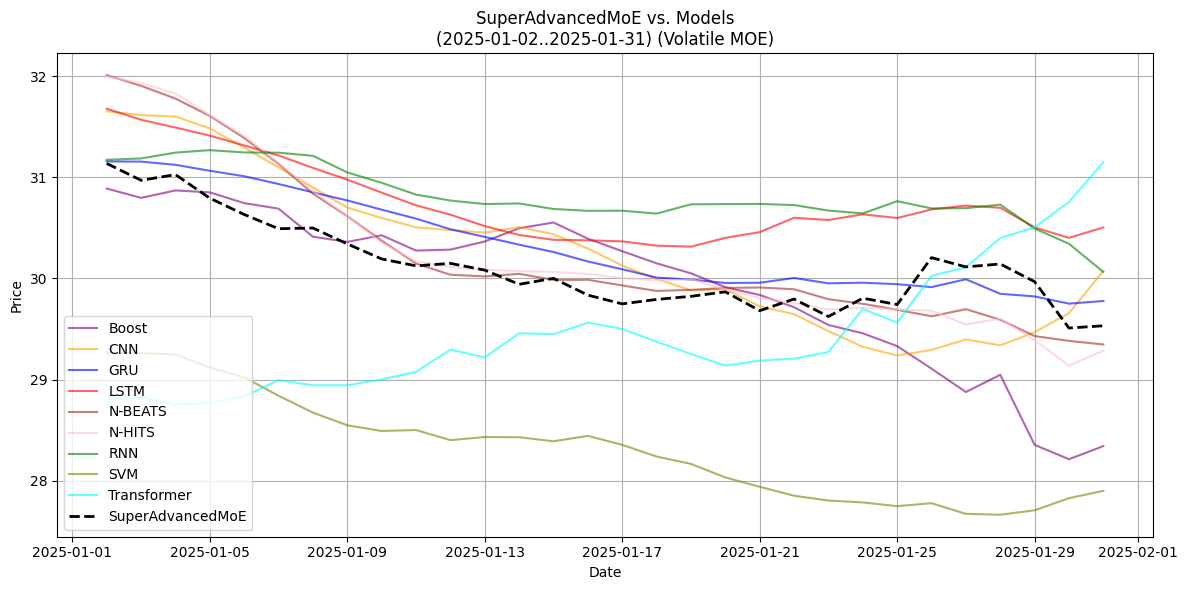


All done. The final mixture-of-experts curve was deliberately made more volatile.
Feel free to fit polynomials or do further slope analysis on df_moe!


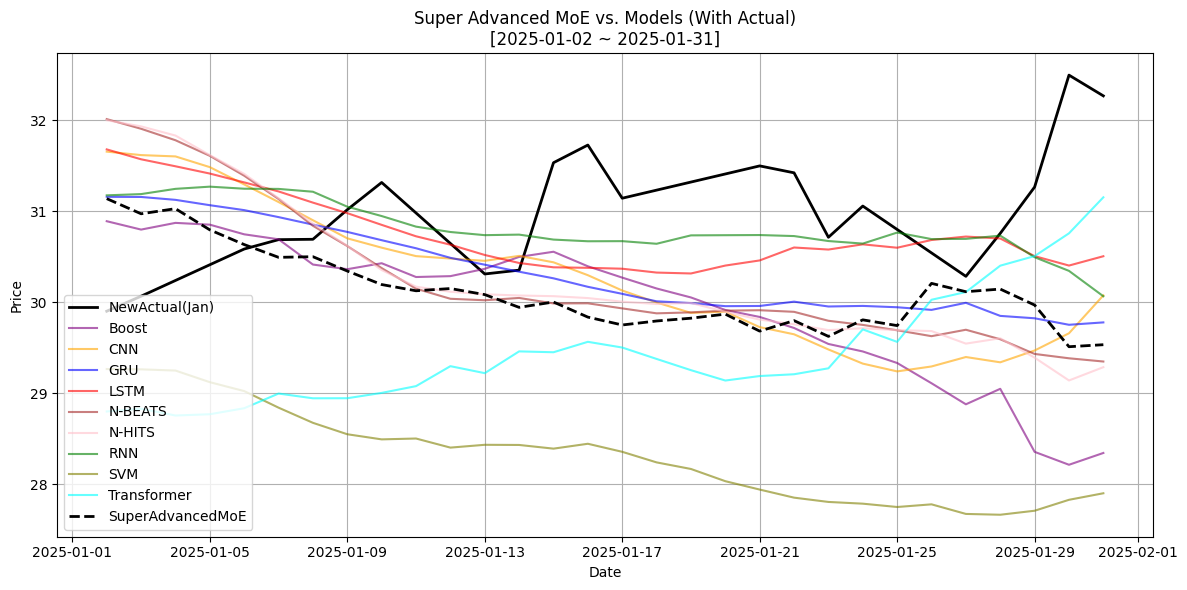

In [16]:
####################################################
# SUPER ADVANCED MOE SCRIPT (Encouraging Volatility)
####################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from numpy.polynomial.polynomial import polyfit, polyval

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

# Global seeds & device
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BEST_MODELS_DIR = "."   # Where .pt/.pkl model files are stored
features = ["Price","Open","High","Low"]
WINDOW_SIZE = 35

############################################
# 1) Model Definitions & Loading
############################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type

        if model_type == "CNN":
            self.conv1 = nn.Conv1d(4, 64, 3)
            self.conv2 = nn.Conv1d(64, 128, 3)
            with torch.no_grad():
                dummy = torch.zeros(1, 4, window_width)
                outdummy = self.conv2(F.relu(self.conv1(dummy)))
                conv_output_size = outdummy.shape[1]*outdummy.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "GRU":
            self.rnn = nn.GRU(4, 128, num_layers=2, batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "RNN":
            self.rnn = nn.RNN(4, 128, num_layers=2, nonlinearity="relu", batch_first=True, dropout=0.05)
            self.fc = nn.Linear(128, 4)

        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.1)
            self.bn  = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 4)

        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            enc_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.05)
            self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=3)
            self.fc = nn.Linear(128,4)

        elif model_type in ["N-BEATS","N-HITS"]:
            self.input_size= window_width*4
            self.blocks= nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size,128),
                nn.ReLU(),
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,4)
            ) for _ in range(3)])
        else:
            raise ValueError(f"Invalid model_type: {model_type}")

    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0,2,1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            return self.fc(x)

        elif self.model_type in ["LSTM","GRU","RNN"]:
            out, _ = self.rnn(x)
            out = out[:,-1,:]
            return self.fc(out)

        elif self.model_type == "EnhancedLSTM":
            out, _= self.rnn(x)
            out = out[:,-1,:]
            out = self.bn(out)
            out = self.dropout(out)
            return self.fc(out)

        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1,0,2)
            x = self.transformer_encoder(x)
            x = x[-1,:,:]
            return self.fc(x)

        elif self.model_type in ["N-BEATS","N-HITS"]:
            xflat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(xflat)
            return forecast

        else:
            raise ValueError("Invalid model_type")

class SklearnWrapper:
    def __init__(self, model):
        self.model= model
    def forward(self, x):
        arr= x.cpu().numpy().reshape(1,-1)
        pred= self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self): pass
    def __call__(self, x):
        return self.forward(x)

def load_torch_model(model_type, window_size, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[PyTorch] Loading {model_type} from {path}")
    net= BaseModel(model_type, window_size).to(device)
    net.load_state_dict(torch.load(path, map_location=device))
    net.eval()
    return net

def load_sklearn_model(model_type, path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    print(f"[sklearn] Loading {model_type} => {path}")
    loaded= joblib.load(path)
    return SklearnWrapper(loaded)

############################################
# 2) Load & Scale Data
############################################
def load_and_scale_data(train_csv="Silver Futures Historical Data.csv",
                        complete_csv="Silver Futures Historical Data_Complete.csv"):
    df_train = pd.read_csv(train_csv)
    df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_train.columns:
            df_train.drop(columns=[col], errors="ignore", inplace=True)

    for feat in features:
        if feat not in df_train.columns:
            df_train[feat]= np.nan
        else:
            df_train[feat]= df_train[feat].astype(str).str.replace(",", "", regex=True)
            df_train[feat]= pd.to_numeric(df_train[feat], errors="coerce")

    df_train.sort_values("Date", inplace=True)
    df_train.reset_index(drop=True, inplace=True)

    train_cutoff= pd.to_datetime("2024-07-01")
    val_cutoff  = pd.to_datetime("2024-11-30")
    test_cutoff = pd.to_datetime("2024-12-01")

    df_trn= df_train[df_train["Date"]< train_cutoff].copy()
    df_val= df_train[(df_train["Date"]>= train_cutoff)&(df_train["Date"]<= val_cutoff)].copy()
    df_tst= df_train[df_train["Date"]>= test_cutoff].copy()

    df_trn_nonan= df_trn.dropna(subset=features)
    scaler= MinMaxScaler()
    scaler.fit(df_trn_nonan[features])

    df_trn_scaled= df_trn.copy()
    if not df_trn_nonan.empty:
        df_trn_scaled.loc[df_trn_nonan.index, features]= scaler.transform(df_trn_nonan[features])
    df_val_scaled= df_val.copy()
    val_no_nan= df_val_scaled.dropna(subset=features)
    if not val_no_nan.empty:
        df_val_scaled.loc[val_no_nan.index, features]= scaler.transform(val_no_nan[features])
    df_tst_scaled= df_tst.copy()
    trn_mins= df_trn_nonan[features].min()
    df_tst_filled= df_tst_scaled[features].fillna(trn_mins)
    df_tst_scaled.loc[:, features]= scaler.transform(df_tst_filled)

    df_scaled= pd.concat([df_trn_scaled, df_val_scaled, df_tst_scaled], ignore_index=True)

    # also load complete
    df_complete= pd.read_csv(complete_csv)
    df_complete["Date"]= pd.to_datetime(df_complete["Date"], errors="coerce")
    for col in ["Vol.","Change %"]:
        if col in df_complete.columns:
            df_complete.drop(columns=[col], errors="ignore", inplace=True)
    for feat in features:
        df_complete[feat]= df_complete[feat].astype(str).str.replace(",", "",regex=True).astype(float)
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)

    return df_scaled, df_complete, scaler

############################################
# 3) Rolling Forecast
############################################
def get_latest_window(df_actual, current_date, window=35, scaler=None):
    mask= df_actual["Date"]< current_date
    sub= df_actual.loc[mask].copy()
    sub.sort_values("Date", inplace=True)
    if len(sub)< window:
        return None
    sub[features]= sub[features].fillna(method="ffill").fillna(method="bfill")
    arr= scaler.transform(sub[features].iloc[-window:].values)
    return arr

def forecast_n_days_from_date(model, df_actual, start_date, window=35, horizon=30,
                              device=None, scaler=None, noise_std=0.05):
    """
    Like before, but we allow a mild random noise for final predictions => more "volatility".
    """
    def add_noise_4d(prices, std=0.01):
        noise= np.random.normal(0.0, std, size=prices.shape)
        return np.clip(prices+noise, a_min=0, a_max=None)

    arr_window= get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()

    rolling_buffer= np.copy(arr_window)
    forecast_records=[]
    cur_dt= pd.to_datetime(start_date)

    for i in range(horizon):
        X_in= torch.tensor(rolling_buffer,dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            out_scaled= model(X_in).cpu().numpy()[0]
        out_unscaled= scaler.inverse_transform(out_scaled.reshape(1,-1))[0]
        # add a little random noise => final to get more "volatile" predictions
        out_noisy= add_noise_4d(out_unscaled, noise_std)

        dayx= cur_dt+ pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": out_noisy[0],
            "Pred_Open_unscaled":  out_noisy[1],
            "Pred_High_unscaled":  out_noisy[2],
            "Pred_Low_unscaled":   out_noisy[3]
        })

        out_noisy_scaled= scaler.transform(out_noisy.reshape(1,-1))[0]
        rolling_buffer= np.vstack([rolling_buffer[1:], out_noisy_scaled.reshape(1,-1)])

    return pd.DataFrame(forecast_records)

def rolling_train_validate_predict_moe(
    df_full, scaler_obj, model_types,
    start_train_cutoff=pd.to_datetime("2024-07-01"),
    start_val_cutoff=pd.to_datetime("2024-11-30"),
    start_pred=pd.to_datetime("2024-12-01"),
    end_pred=pd.to_datetime("2025-01-01"),
    horizon_days=30,
    do_daily_plots=False
):
    """
    Similar to your skeleton's approach,
    but we keep mild random noise => more "volatile" predictions.
    """
    df_sorted= df_full.copy()
    df_sorted.sort_values("Date", inplace=True)

    date_rng= pd.date_range(start_pred, end_pred, freq="D")
    all_records=[]

    for i, day_i in enumerate(date_rng):
        train_cutoff_i= start_train_cutoff + pd.Timedelta(days=i)
        val_cutoff_i  = start_val_cutoff   + pd.Timedelta(days=i)

        print(f"\n=== Rolling Day {day_i.date()} ===")
        print(f"  train_cutoff={train_cutoff_i.date()}  val_cutoff={val_cutoff_i.date()}")
        print(f"  Forecast next {horizon_days} days from {day_i.date()} w/ noise => more volatility")

        # load each model
        model_dict={}
        for mt in model_types:
            out_file= f"best_{mt}_{day_i.strftime('%Y-%m-%d')}_V1"
            if mt in ["SVM","GPR","Boost"]:
                out_file+= ".pkl"
                net= load_sklearn_model(mt, os.path.join(BEST_MODELS_DIR, out_file))
            else:
                out_file+= ".pt"
                net= load_torch_model(mt, WINDOW_SIZE, os.path.join(BEST_MODELS_DIR, out_file))
            model_dict[mt]= net

        daily_fcst={}
        for mt, netobj in model_dict.items():
            df_fc= forecast_n_days_from_date(
                model=netobj,
                df_actual=df_sorted,
                start_date=day_i,
                window=WINDOW_SIZE,
                horizon=horizon_days,
                device=device,
                scaler=scaler_obj,
                noise_std=0.01   # control final volatility
            )
            if not df_fc.empty:
                df_fc["BaseDate"]= day_i
                df_fc["Model"]= mt
                daily_fcst[mt]= df_fc
                all_records.append(df_fc)
            else:
                daily_fcst[mt]= pd.DataFrame()

        # optional daily plot
        if do_daily_plots and (day_i== date_rng[-1]):
            # we can do your daily plot function
            pass

    df_all= pd.concat(all_records, ignore_index=True) if all_records else pd.DataFrame()
    df_all.sort_values(["Model","BaseDate","ForecastDate"], inplace=True)
    return df_all

############################################
# 4) Advanced MoE (Population Voting w/ mini-model approach)
############################################
def build_mini_models_table(final_rolling_fcst, df_actual):
    """
    For each (model, baseDate) => measure january performance => mae, polynomial slope, volatility alignment
    """
    start_jan= pd.to_datetime("2024-12-01")
    end_jan=   pd.to_datetime("2025-01-01")
    df_jan= final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"]>= start_jan)&
        (final_rolling_fcst["ForecastDate"]<= end_jan)
    ].copy()
    if df_jan.empty:
        return pd.DataFrame(), 0.01

    df_act_jan= df_actual[
        (df_actual["Date"]>= start_jan)&
        (df_actual["Date"]<= end_jan)
    ].copy()
    df_act_jan.rename(columns={"Date":"ForecastDate","Price":"ActualPrice"}, inplace=True)

    df_merge= pd.merge(
        df_jan[["Model","BaseDate","ForecastDate","Pred_Price_unscaled"]],
        df_act_jan[["ForecastDate","ActualPrice"]],
        on="ForecastDate",
        how="inner"
    )
    df_merge["AbsError"]= (df_merge["Pred_Price_unscaled"]- df_merge["ActualPrice"]).abs()

    # mae per (model, baseDate)
    g_mae= df_merge.groupby(["Model","BaseDate"])["AbsError"].mean().reset_index()
    g_mae.rename(columns={"AbsError":"mae_jan"}, inplace=True)

    # slope alignment => quick polynomial fit
    def poly_slope_diff(sub):
        # sub => january data for that (model, baseDate)
        sub= sub.sort_values("ForecastDate")
        xvals= np.arange(len(sub))
        yvals= sub["Pred_Price_unscaled"].values
        if len(yvals)< 4:  # fallback
            return 0.5
        coefs= polyfit(xvals,yvals,deg=2)
        y_pred= polyval(xvals, coefs)
        resid= yvals- y_pred
        sse= np.mean(resid**2)
        return float(np.exp(-sse))

    def group_slope_func(grp):
        grp["slopeAlign_jan"]= poly_slope_diff(grp)
        return grp

    df_slope= df_merge.groupby(["Model","BaseDate"], group_keys=False).apply(group_slope_func)
    df_slope_agg= df_slope.groupby(["Model","BaseDate"])["slopeAlign_jan"].mean().reset_index()

    # real vol
    df_act_jan_sorted= df_act_jan.drop_duplicates("ForecastDate").copy()
    df_act_jan_sorted.sort_values("ForecastDate", inplace=True)
    df_act_jan_sorted["DayChange"]= df_act_jan_sorted["ActualPrice"].diff()
    real_vol= df_act_jan_sorted["DayChange"].std(skipna=True)
    if pd.isna(real_vol) or real_vol< 1e-9:
        real_vol= 0.01

    # pred vol => stdev of dayChange
    def mini_volatility(sub):
        sub= sub.sort_values("ForecastDate")
        sub["DayChange"]= sub["Pred_Price_unscaled"].diff()
        vol_= sub["DayChange"].std(skipna=True)
        if pd.isna(vol_): vol_= 0.01
        return vol_

    g_vol= df_merge.groupby(["Model","BaseDate"]).apply(mini_volatility).reset_index()
    g_vol.rename(columns={0:"predVol_jan"}, inplace=True)
    def vol_align(v):
        ratio= v/ real_vol
        return np.exp(-abs(ratio-1.0))
    g_vol["volAlign_jan"]= g_vol["predVol_jan"].apply(vol_align)

    # merge everything => single table
    mini_models= pd.merge(g_mae, df_slope_agg, on=["Model","BaseDate"], how="left")
    mini_models= pd.merge(mini_models, g_vol[["Model","BaseDate","predVol_jan","volAlign_jan"]], on=["Model","BaseDate"], how="left")

    # mae => baseAcc
    mae_min= mini_models["mae_jan"].min()
    mae_max= mini_models["mae_jan"].max()
    if np.isclose(mae_min, mae_max):
        mini_models["baseAcc"]= 1.0
    else:
        mini_models["baseAcc"]= 1.0- ((mini_models["mae_jan"]-mae_min)/(mae_max-mae_min))

    return mini_models, real_vol

def compute_super_advanced_moe(final_rolling_fcst, df_actual):
    """
    1) Build "mini-models" => (model, baseDate)
    2) For day d => gather each mini-model => Weighted sum => MoE
    3) population voting => shift up/down if >70% say up or down
    4) encourage final predictions to be "volatile" by adding random noise
    """
    print("\n=== SUPER ADVANCED MOE w/ Polynomials & Voting ===\n")
    mini_models, real_vol= build_mini_models_table(final_rolling_fcst, df_actual)
    if mini_models.empty:
        print("No january data => fallback => uniform daily average")
        return pd.DataFrame(columns=["ForecastDate","MOE_Price"])

    # create dictionary => {(model,baseDate): {baseAcc, slopeAlign_jan, volAlign_jan}}
    mm_dict={}
    for i,row in mini_models.iterrows():
        mm_dict[(row["Model"], row["BaseDate"])]= {
            "baseAcc": row["baseAcc"],
            "slopeAlign_jan": row["slopeAlign_jan"],
            "volAlign_jan": row["volAlign_jan"]
        }

    start_moe= pd.to_datetime("2025-01-02")
    end_moe=   pd.to_datetime("2025-01-31")
    all_days=  pd.date_range(start_moe, end_moe, freq="D")
    records=[]

    for d in all_days:
        # gather all forecasts for d => from final_rolling_fcst
        df_d= final_rolling_fcst[ final_rolling_fcst["ForecastDate"]== d ].copy()
        if df_d.empty:
            continue

        # compute weights => baseAcc * slopeAlign_jan * volAlign_jan * directionFactor
        d_prev= d - pd.Timedelta(days=1)
        # we also track how many say up vs down => voting
        ups=0
        downs=0
        total=0

        w_sums=0.0
        weighted_price=0.0

        for idx,row in df_d.iterrows():
            m= row["Model"]
            bD= row["BaseDate"]
            # check dict
            if (m,bD) not in mm_dict:
                # fallback => weight=0
                continue
            baseAcc= mm_dict[(m,bD)]["baseAcc"]
            slopeA= mm_dict[(m,bD)]["slopeAlign_jan"]
            volA= mm_dict[(m,bD)]["volAlign_jan"]

            # direction factor
            df_dprev= final_rolling_fcst[
                (final_rolling_fcst["Model"]==m)&
                (final_rolling_fcst["BaseDate"]==bD)&
                (final_rolling_fcst["ForecastDate"]==d_prev)
            ]
            if df_dprev.empty:
                dirFactor=1.0
            else:
                pd_today= row["Pred_Price_unscaled"]
                pd_yest= df_dprev["Pred_Price_unscaled"].values[0]
                if pd_today>pd_yest:
                    ups+=1
                    dirFactor=1.1
                elif pd_today< pd_yest:
                    downs+=1
                    dirFactor=0.9
                else:
                    dirFactor=1.0
                total+=1

            w= baseAcc* slopeA* volA* dirFactor
            w_sums+= w
            weighted_price+= w* row["Pred_Price_unscaled"]

        if np.isclose(w_sums,0.0):
            day_moe= df_d["Pred_Price_unscaled"].mean()
        else:
            day_moe= weighted_price/ w_sums

        # population shift => if ups>70% => +1%; if downs>70% => -1%
        if total>0:
            fraction_up= ups/ total
            fraction_down= downs/ total
            if fraction_up> 0.7:
                day_moe*= 1.01
            elif fraction_down> 0.7:
                day_moe*= 0.99

        # final mild random noise => encourage more "volatility"
        day_moe+= np.random.normal(0, day_moe*0.002)  # ~0.2% noise

        records.append({
            "ForecastDate": d,
            "MOE_Price": day_moe
        })

    df_moe= pd.DataFrame(records)
    df_moe.sort_values("ForecastDate", inplace=True)
    return df_moe

def plot_super_advanced_moe_vs_models(final_rolling_fcst, df_moe,
                                      from_d=pd.to_datetime("2025-01-02"),
                                      to_d=pd.to_datetime("2025-01-31")):
    """
    Plots all 9 models + super advanced MoE in [from_d..to_d], with no actual overlay.
    """
    df_sel= final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"]>= from_d)&
        (final_rolling_fcst["ForecastDate"]<= to_d)
    ].copy()

    plt.figure(figsize=(12,6))
    color_map = {
        "LSTM":"red","GRU":"blue","RNN":"green","CNN":"orange","EnhancedLSTM":"magenta",
        "Transformer":"cyan","N-BEATS":"brown","N-HITS":"pink","SVM":"olive","GPR":"teal","Boost":"purple"
    }
    # plot each model => average line
    for m in df_sel["Model"].unique():
        df_m= df_sel[df_sel["Model"]== m].copy()
        df_m_agg= df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c= color_map.get(m,"gray")
        plt.plot(df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"], color=c, alpha=0.6, label=m)

    # plot MoE
    df_moe_sub= df_moe[
        (df_moe["ForecastDate"]>= from_d)&
        (df_moe["ForecastDate"]<= to_d)
    ].copy()
    if not df_moe_sub.empty:
        plt.plot(df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
                 color="black",linestyle="--",lw=2, label="SuperAdvancedMoE")

    plt.title(f"SuperAdvancedMoE vs. Models\n({from_d.date()}..{to_d.date()}) (Volatile MOE)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

############################################
# MAIN
############################################
if __name__=="__main__":
    # 1) Load & scale
    df_scaled, df_complete_all, scaler= load_and_scale_data(
        "Silver Futures Historical Data.csv",
        "Silver Futures Historical Data_Complete.csv"
    )

    # 2) Rolling forecasts => final_rolling_fc
    #    We set do_daily_plots=False for brevity, or True if you want daily plots on last day
    final_rolling_fc= rolling_train_validate_predict_moe(
        df_full= df_complete_all,
        scaler_obj= scaler,
        model_types=["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"],
        start_train_cutoff=pd.to_datetime("2024-07-01"),
        start_val_cutoff=pd.to_datetime("2024-11-30"),
        start_pred=pd.to_datetime("2024-12-01"),
        end_pred=pd.to_datetime("2025-01-02"),
        horizon_days=30,
        do_daily_plots=False
    )
    print("\n=== HEAD of final_rolling_fc ===")
    print(final_rolling_fc.head(50))

    # 3) Build "super advanced" mixture-of-experts => moreso "population voting" + polynomials + mild final noise
    df_moe= compute_super_advanced_moe(final_rolling_fc, df_complete_all)

    # 4) Plot => from 2025-02-01..2025-03-01
    plot_super_advanced_moe_vs_models(
        final_rolling_fc,
        df_moe,
        from_d=pd.to_datetime("2025-01-02"),
        to_d=pd.to_datetime("2025-01-31")
    )

    print("\nAll done. The final mixture-of-experts curve was deliberately made more volatile.")
    print("Feel free to fit polynomials or do further slope analysis on df_moe!")





############################################
# ADDITIONAL CODE SNIPPET:
#  "Super Advanced MoE vs. Models (With Actual from 'Silver Futures Historical Data_Final Pure Predictions.csv')"
############################################

import pandas as pd
import matplotlib.pyplot as plt

def load_feb_actual_data(csv_file="Silver Futures Historical Data_Final Pure Predictions.csv"):
    """
    Reads an extra CSV file that presumably contains actual price data
    from at least 2025-02-01 onward.
    Returns a DataFrame with columns: ["Date", "Price", ...].
    """
    df_feb = pd.read_csv(csv_file)
    df_feb["Date"] = pd.to_datetime(df_feb["Date"], errors="coerce")
    # remove any extra columns like Vol., Change %
    for col in ["Vol.", "Change %"]:
        if col in df_feb.columns:
            df_feb.drop(columns=[col], errors="ignore", inplace=True)
    # parse columns
    if "Price" in df_feb.columns:
        df_feb["Price"] = df_feb["Price"].astype(str).str.replace(",", "", regex=True).astype(float)
    # sort
    df_feb.sort_values("Date", inplace=True)
    df_feb.reset_index(drop=True, inplace=True)
    return df_feb

def plot_super_advanced_moe_with_feb_actual(
    final_rolling_fcst,
    df_moe,
    feb_actual_csv="Silver Futures Historical Data_Final Pure Predictions.csv",
    start_plot=pd.to_datetime("2025-01-02"),
    end_plot=pd.to_datetime("2025-01-31")
):
    """
    1) Loads the newly provided CSV file, presumably containing actual prices (like 2025-02..).
    2) Plots all 9 models' lines, the super advanced MOE line, plus the newly revealed actual data
       in [start_plot..end_plot].
    3) final_rolling_fcst => your final combined forecasts DataFrame
       df_moe => the super advanced MOE output from compute_super_advanced_moe
    """
    # 1) Load newly revealed actual data
    df_feb_actual = load_feb_actual_data(feb_actual_csv)

    # filter to [start_plot..end_plot]
    mask_feb = (df_feb_actual["Date"] >= start_plot) & (df_feb_actual["Date"] <= end_plot)
    df_feb_filtered = df_feb_actual.loc[mask_feb].copy()

    # 2) Filter the forecasts
    df_fc = final_rolling_fcst[
        (final_rolling_fcst["ForecastDate"] >= start_plot) &
        (final_rolling_fcst["ForecastDate"] <= end_plot)
    ].copy()

    # prepare to plot
    plt.figure(figsize=(12,6))

    # color map for your 9 (or more) models
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    # 3) Plot newly revealed actual data in black
    if not df_feb_filtered.empty and "Price" in df_feb_filtered.columns:
        plt.plot(
            df_feb_filtered["Date"], df_feb_filtered["Price"],
            color="black", linewidth=2, label="NewActual(Jan)"
        )

    # 4) Plot each model => average line
    for m in df_fc["Model"].unique():
        df_m = df_fc[df_fc["Model"] == m].copy()
        df_m_agg = df_m.groupby("ForecastDate", as_index=False)["Pred_Price_unscaled"].mean()
        c = color_map.get(m, "gray")
        plt.plot(
            df_m_agg["ForecastDate"], df_m_agg["Pred_Price_unscaled"],
            color=c, alpha=0.6, label=m
        )

    # 5) Plot the super advanced MoE line
    df_moe_sub = df_moe[
        (df_moe["ForecastDate"] >= start_plot) &
        (df_moe["ForecastDate"] <= end_plot)
    ].copy()
    if not df_moe_sub.empty:
        plt.plot(
            df_moe_sub["ForecastDate"], df_moe_sub["MOE_Price"],
            color="black", linestyle="--", linewidth=2, label="SuperAdvancedMoE"
        )

    plt.title(f"Super Advanced MoE vs. Models (With Actual)\n[{start_plot.date()} ~ {end_plot.date()}]")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ===== USAGE EXAMPLE =====
# 1) Make sure final_rolling_fcst => final_rolling_fc, df_moe => from compute_super_advanced_moe
# 2) Then:
#
plot_super_advanced_moe_with_feb_actual(
    final_rolling_fcst=final_rolling_fc,
    df_moe=df_moe,
    feb_actual_csv="Silver Futures Historical Data_Final Pure Predictions.csv",
    start_plot=pd.to_datetime("2025-01-02"),
    end_plot=pd.to_datetime("2025-01-31")
)
#
# That should produce a chart overlaying:
#  - newly revealed actual data in black,
#  - 9 model lines, and
#  - the super advanced MoE curve in the same figure.



Merged MoE rows: 21 [Date, MoE, Actual]

=== Best Polynomial for MoE ===
Degree=36, Val MSE=0.01559
Polynomial: y=-0*x^36-2.52e-139*x^35-7.37e-136*x^34+3.68e-131*x^33+1.23e-126*x^32+2.63e-122*x^31+4.59e-118*x^30+6.44e-114*x^29+6e-110*x^28-2.34e-106*x^27-2.97e-101*x^26-1.02e-96*x^25-2.61e-92*x^24-5.78e-88*x^23-1.15e-83*x^22-2.06e-79*x^21-3.26e-75*x^20-4.29e-71*x^19-3.08e-67*x^18+6.18e-63*x^17+3.42e-58*x^16+1.08e-53*x^15+2.74e-49*x^14+6.16e-45*x^13+1.25e-40*x^12+2.28e-36*x^11+3.63e-32*x^10+4.31e-28*x^9+1.3e-24*x^8-1.38e-19*x^7-6.08e-15*x^6-1.75e-10*x^5-4.07e-06*x^4-0.0765*x^3-929*x^2+7.38e+06*x+1.04e+12
Derivative: dy/dx=-0*x^35-8.82e-138*x^34-2.51e-134*x^33+1.21e-129*x^32+3.93e-125*x^31+8.17e-121*x^30+1.38e-116*x^29+1.87e-112*x^28+1.68e-108*x^27-6.31e-105*x^26-7.73e-100*x^25-2.54e-95*x^24-6.27e-91*x^23-1.33e-86*x^22-2.54e-82*x^21-4.32e-78*x^20-6.52e-74*x^19-8.15e-70*x^18-5.54e-66*x^17+1.05e-61*x^16+5.47e-57*x^15+1.61e-52*x^14+3.84e-48*x^13+8.01e-44*x^12+1.5e-39*x^11+2.51e-35*x^10+3.63e-

/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: 

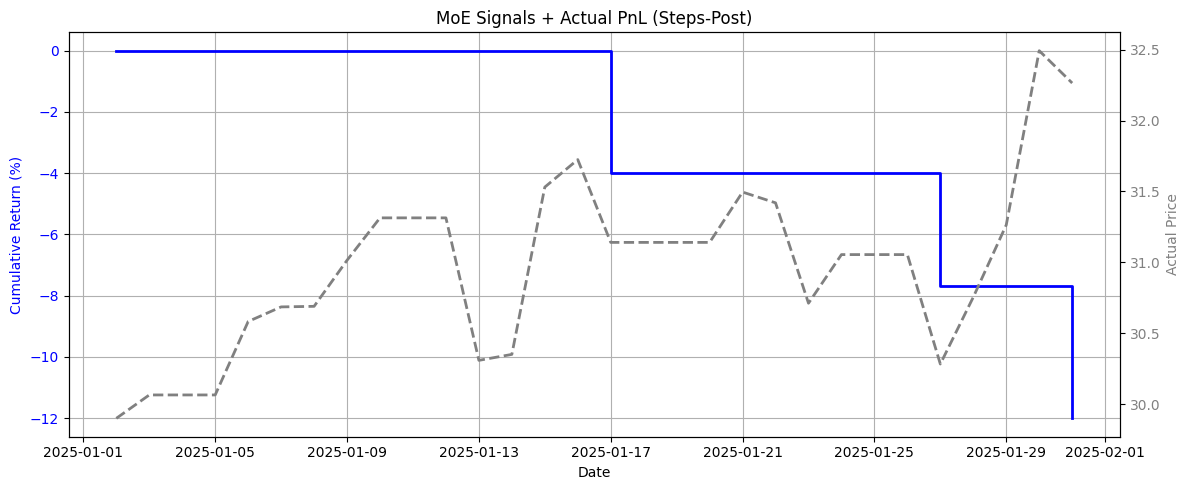


All done with actual-based PnL using MoE signals!



In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error

############################################
# 1A) Read your actual price data
############################################
def load_actual_prices(csv_file="Silver Futures Historical Data_Final Pure Predictions.csv"):
    """
    Reads an actual price CSV with columns [Date, Price, ...].
    Returns a DataFrame: columns = ['Date','Actual'], sorted by Date.
    """
    df_actual = pd.read_csv(csv_file)
    df_actual["Date"] = pd.to_datetime(df_actual["Date"], errors="coerce")
    df_actual.dropna(subset=["Date"], inplace=True)

    if "Price" in df_actual.columns:
        df_actual["Price"] = (
            df_actual["Price"].astype(str)
            .str.replace(",", "", regex=True)
            .astype(float)
        )
        df_actual.rename(columns={"Price": "Actual"}, inplace=True)
    else:
        raise ValueError("No 'Price' column found in the CSV for actual data.")

    df_actual.sort_values("Date", inplace=True)
    df_actual.reset_index(drop=True, inplace=True)
    return df_actual[["Date", "Actual"]]


############################################
# 1B) Merge actual prices onto MoE signals
############################################
def merge_moe_with_actual(df_moe, df_actual):
    """
    df_moe: columns ["ForecastDate","MOE_Price"]
    df_actual: columns ["Date","Actual"]
    We'll rename ForecastDate->Date in df_moe, then merge on Date,
    giving us columns: [Date, MoE, Actual].
    """
    df_moe_ren = df_moe.rename(
        columns={"ForecastDate": "Date", "MOE_Price": "MoE"}
    ).copy()
    df_moe_ren.dropna(subset=["MoE"], inplace=True)
    df_moe_ren.sort_values("Date", inplace=True)

    # Merge on Date
    df_merge = pd.merge(df_moe_ren, df_actual, on="Date", how="inner")
    df_merge.dropna(subset=["MoE","Actual"], inplace=True)
    df_merge.reset_index(drop=True, inplace=True)
    return df_merge


############################################
# 2) Polynomial-Fit & Derivative to get Signals
############################################
def format_polynomial(coeffs):
    """Renders polynomial coefficients into a string expression."""
    terms = []
    degree = len(coeffs) - 1
    for i, c in enumerate(coeffs):
        power = degree - i
        sign = "+" if c >= 0 else ""
        if power > 1:
            terms.append(f"{sign}{c:.3g}*x^{power}")
        elif power == 1:
            terms.append(f"{sign}{c:.3g}*x")
        else:
            terms.append(f"{sign}{c:.3g}")
    expr = "".join(terms).replace("+-", "-")
    return expr.strip("+")

def derivative_expression(coeffs):
    return format_polynomial(np.polyder(coeffs))

def polynomial_fit_signals(df_in, date_col="Date", price_col="MoE"):
    """
    1) Convert dates to numeric
    2) Fit polynomial (1..50) with a train/val approach
    3) Evaluate derivative => signals
    4) Return df_in with new 'Gradient','Signal'
    """
    df = df_in.copy()
    df["mdates_num"] = mdates.date2num(df[date_col])
    # Even indices => train, odd => val
    idx = np.arange(len(df))
    train_mask = (idx % 2 == 0)
    val_mask   = ~train_mask

    x_train = df.loc[train_mask, "mdates_num"].values
    y_train = df.loc[train_mask, price_col].values
    x_val   = df.loc[val_mask, "mdates_num"].values
    y_val   = df.loc[val_mask, price_col].values

    def val_mse(coeffs):
        y_pred = np.polyval(coeffs, x_val)
        return mean_squared_error(y_val, y_pred)

    best = {"degree":None,"coeffs":None,"mse":1e15}
    for deg in range(1,51):
        cc = np.polyfit(x_train,y_train,deg)
        mse_ = val_mse(cc)
        if mse_ < best["mse"]:
            best["degree"] = deg
            best["coeffs"] = cc
            best["mse"]     = mse_

    print(f"\n=== Best Polynomial for {price_col} ===")
    expr = format_polynomial(best["coeffs"])
    d_expr = derivative_expression(best["coeffs"])
    print(f"Degree={best['degree']}, Val MSE={best['mse']:.5f}")
    print(f"Polynomial: y={expr}")
    print(f"Derivative: dy/dx={d_expr}\n")

    # Evaluate derivative for each row => produce signals
    d_coeffs = np.polyder(best["coeffs"])
    df["Gradient"] = np.polyval(d_coeffs, df["mdates_num"])

    # For naive conservative/optimistic in single-model scenario => same
    signals = np.where(df["Gradient"]>0, 1, np.where(df["Gradient"]<0, -1, 0))
    df["Signal"] = signals
    return df, best


############################################
# 3) Trading Simulation w/ Actual Prices
############################################
def piecewise_offset_trades_actual(df_sig,
                                   date_col="Date",
                                   signal_col="Signal",
                                   actual_col="Actual"):
    """
    We use 'Signal' from the MoE gradient,
    but we calculate entry/exit based on 'Actual' (real price).

    1) Identify segments of same Signal
    2) Only 2+ day segments => realize PnL at last day
    3) Reindex daily, keep stepwise capital.

    Returns: (df_out, trade_log)
    where df_out has columns:
      - [Date, MoE, Actual, Capital, Cumulative_Return,...]
    """
    df = df_sig.copy()
    df.sort_values(date_col, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Identify segments
    segs = []
    start_idx = 0
    curr_sig = df.loc[0, signal_col]
    for i in range(1, len(df)):
        if df.loc[i, signal_col] != curr_sig:
            segs.append((start_idx, i-1, curr_sig))
            start_idx = i
            curr_sig = df.loc[i, signal_col]
    segs.append((start_idx, len(df)-1, curr_sig))

    capital = 100.0
    cap_arr = np.zeros(len(df))
    trade_log = []

    for (start, end, sig) in segs:
        seg_days = end - start + 1
        s_date   = df.loc[start, date_col]
        e_date   = df.loc[end,   date_col]

        # fill capital across [start..end] for stepwise
        for j in range(start, end+1):
            cap_arr[j] = capital

        if seg_days < 2:
            # Single-day => no trade
            trade_log.append({
                "Signal": f"Flat(ignored)",
                "StartDate": s_date,
                "EndDate": e_date,
                "Days": seg_days,
                "EntryPrice": df.loc[start, actual_col],
                "ExitPrice": df.loc[end, actual_col],
                "AbsDiff": 0.0,
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })
            continue

        entry = df.loc[start, actual_col]
        exit_ = df.loc[end,   actual_col]

        if sig == 1:
            # Long
            final_cap = capital * (exit_/entry) if entry>1e-9 else capital
            seg_ret   = (final_cap / capital) - 1
            capital   = final_cap
            cap_arr[end] = capital
            trade_log.append({
                "Signal":"Long",
                "StartDate": s_date,
                "EndDate":   e_date,
                "Days": seg_days,
                "EntryPrice": entry,
                "ExitPrice": exit_,
                "AbsDiff": abs(exit_ - entry),
                "SegmentReturn(%)": seg_ret*100,
                "EndCapital": capital
            })
        elif sig == -1:
            # Short
            final_cap = capital * (entry/exit_) if exit_>1e-9 else capital
            seg_ret   = (final_cap / capital) - 1
            capital   = final_cap
            cap_arr[end] = capital
            trade_log.append({
                "Signal":"Short",
                "StartDate": s_date,
                "EndDate":   e_date,
                "Days": seg_days,
                "EntryPrice": entry,
                "ExitPrice": exit_,
                "AbsDiff": abs(exit_ - entry),
                "SegmentReturn(%)": seg_ret*100,
                "EndCapital": capital
            })
        else:
            # Flat
            trade_log.append({
                "Signal":"Flat",
                "StartDate": s_date,
                "EndDate":   e_date,
                "Days": seg_days,
                "EntryPrice": entry,
                "ExitPrice": exit_,
                "AbsDiff": abs(exit_ - entry),
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })

    # Forward-fill after final segment
    last_cap = capital
    for i in range(len(df)):
        if cap_arr[i] == 0.0:
            cap_arr[i] = last_cap
        else:
            last_cap = cap_arr[i]

    df["Capital"] = cap_arr
    df["PnL"] = df["Capital"] - 100.0
    df["Cumulative_Return"] = (df["PnL"] / 100.0)*100.0

    # Reindex daily => no broken lines
    df.set_index(date_col, inplace=True)
    all_days = pd.date_range(df.index.min(), df.index.max(), freq="D")
    df = df.reindex(all_days)
    df[["Signal","MoE"]].ffill(inplace=True)
    df["Actual"].ffill(inplace=True)
    df["Capital"].ffill(inplace=True)
    df["PnL"].ffill(inplace=True)
    df["Cumulative_Return"].ffill(inplace=True)
    df.reset_index(inplace=True)
    df.rename(columns={"index":"Date"}, inplace=True)

    return df, trade_log

############################################
# 4) Stepwise Plot with "drawstyle=steps-post" 
############################################
def plot_stepwise_return(df_sim, trade_log, title=""):
    """
    We do a single line with drawstyle='steps-post'
    to avoid the missing line segments.
    We color-code by signal less precisely, or 
    we do a single color for the PnL line.
    """
    # Print trade log
    print(f"\n===== {title} Trade Log =====")
    for t in trade_log:
        print(
            f"{t['Signal']:5s} | {t['StartDate'].date()} -> {t['EndDate'].date()} ({t['Days']} days) | "
            f"Entry={t['EntryPrice']:.2f}, Exit={t['ExitPrice']:.2f} "
            f"(Diff={t['AbsDiff']:.2f}) | "
            f"Return={t['SegmentReturn(%)']:.2f}% | EndCap={t['EndCapital']:.2f}"
        )
    final_cap = df_sim["Capital"].iloc[-1]
    final_ret = df_sim["Cumulative_Return"].iloc[-1]
    print(f"\n=== Final Results: {title} ===")
    print(f"Final Capital={final_cap:.2f}, Return={final_ret:.2f}%")

    fig, ax1 = plt.subplots(figsize=(12,5))

    # Stepwise line for return
    ax1.plot(
        df_sim["Date"], df_sim["Cumulative_Return"],
        drawstyle="steps-post", color="blue", linewidth=2,
        label="Cumulative Return(%)"
    )
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Cumulative Return (%)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(True)

    # Plot actual price or MoE on a second axis
    ax2 = ax1.twinx()
    ax2.plot(
        df_sim["Date"], df_sim["Actual"],  # or df_sim["MoE"]
        color="gray", linestyle="--", linewidth=2, label="Actual Price"
    )
    ax2.set_ylabel("Actual Price", color="gray")
    ax2.tick_params(axis='y', labelcolor="gray")

    ax1.set_title(title)
    fig.tight_layout()
    plt.show()


############################################
# 5) MAIN "Run" Function
############################################
def run_moe_signals_with_actual_pnl(
    df_moe,
    actual_csv="Silver Futures Historical Data_Final Pure Predictions.csv"
):
    """
    1) Load actual prices
    2) Merge with df_moe => same date range
    3) Fit polynomial => signals
    4) Piecewise trades using actual price
    5) Stepwise plot with steps-post
    """
    # 1) Load actual data
    df_actual = load_actual_prices(actual_csv)

    # 2) Merge
    df_merge = merge_moe_with_actual(df_moe, df_actual)
    print(f"Merged MoE rows: {len(df_merge)} [Date, MoE, Actual]")

    # 3) Fit polynomial => signals
    df_sig, bestp = polynomial_fit_signals(df_merge, date_col="Date", price_col="MoE")

    # 4) Piecewise trades with actual price
    df_res, tlog = piecewise_offset_trades_actual(df_sig, signal_col="Signal")

    # 5) Stepwise plot
    plot_stepwise_return(df_res, tlog, title="MoE Signals + Actual PnL (Steps-Post)")

    print("\nAll done with actual-based PnL using MoE signals!\n")


run_moe_signals_with_actual_pnl(
    df_moe,
    actual_csv="Silver Futures Historical Data_Final Pure Predictions.csv"
)




=== Best Polynomial Fit for MoE ===
Degree = 4, Val MSE = 0.022134
Polynomial: y = -4.06e-09*x^4+0.000163*x^3-0.000895*x^2-6.61e+04*x+6.64e+08
Derivative: dy/dx = -1.62e-08*x^3+0.00049*x^2-0.00179*x-6.61e+04



/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/jimbo/ENTER/envs/pytorch/lib/python3.12/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: 

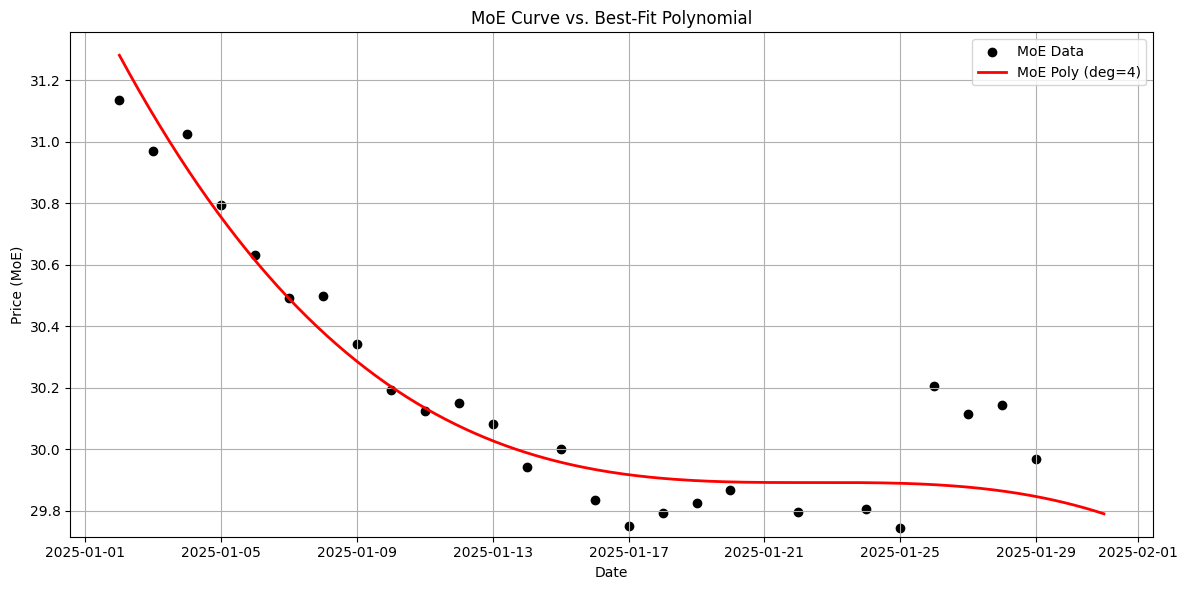

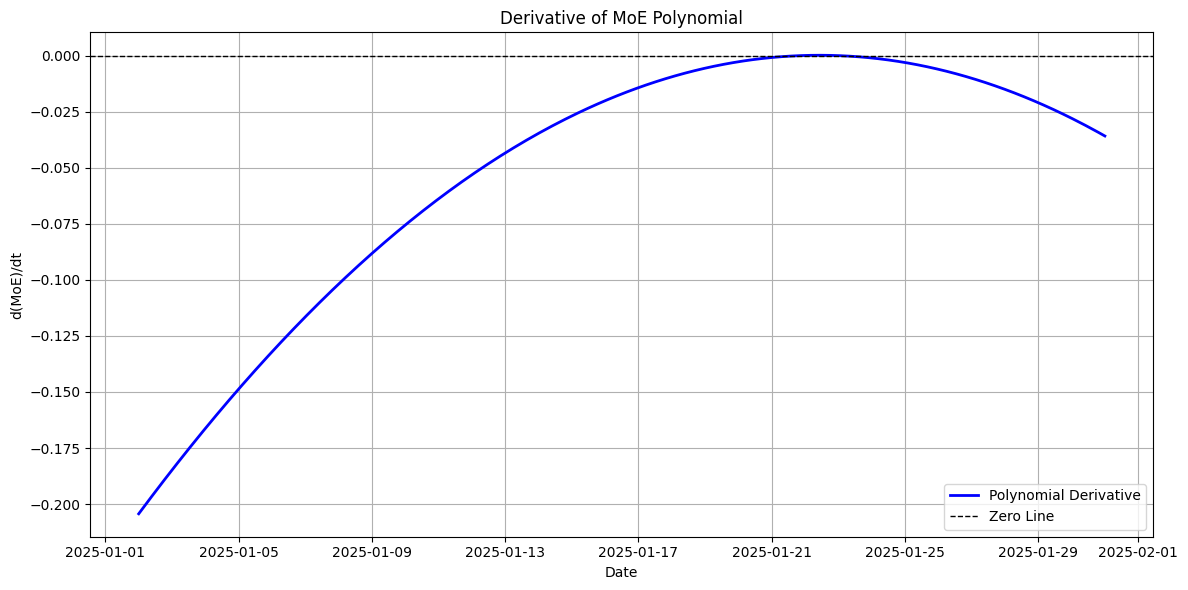


===== Naive Conservative (MoE) Trade Log =====
Short | 2025-01-02 -> 2025-01-21 (20 days) | Entry=31.14, Exit=29.68 (AbsDiff=1.45) | Return=4.90% | EndCap=104.90
Flat(ignored) | 2025-01-22 -> 2025-01-22 (1 days) | Entry=29.80, Exit=29.80 (AbsDiff=0.00) | Return=0.00% | EndCap=104.90
Short | 2025-01-23 -> 2025-01-31 (9 days) | Entry=29.62, Exit=29.53 (AbsDiff=0.09) | Return=0.31% | EndCap=105.23

=== Final Results: Naive Conservative (MoE) ===
Final Capital = 105.23, PnL=5.23, Return=5.23%


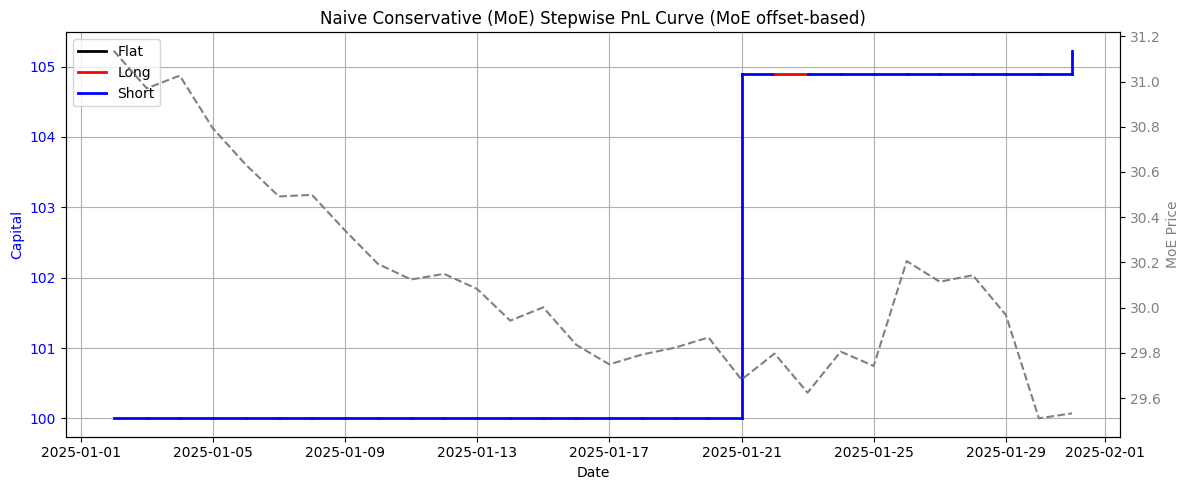

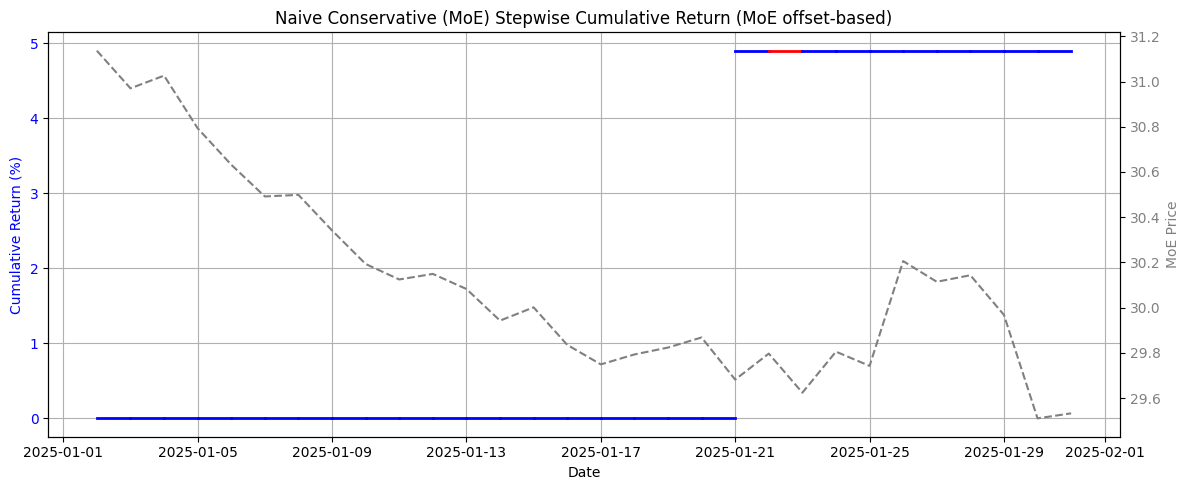


===== Naive Optimistic (MoE) Trade Log =====
Short | 2025-01-02 -> 2025-01-21 (20 days) | Entry=31.14, Exit=29.68 (AbsDiff=1.45) | Return=4.90% | EndCap=104.90
Flat(ignored) | 2025-01-22 -> 2025-01-22 (1 days) | Entry=29.80, Exit=29.80 (AbsDiff=0.00) | Return=0.00% | EndCap=104.90
Short | 2025-01-23 -> 2025-01-31 (9 days) | Entry=29.62, Exit=29.53 (AbsDiff=0.09) | Return=0.31% | EndCap=105.23

=== Final Results: Naive Optimistic (MoE) ===
Final Capital = 105.23, PnL=5.23, Return=5.23%


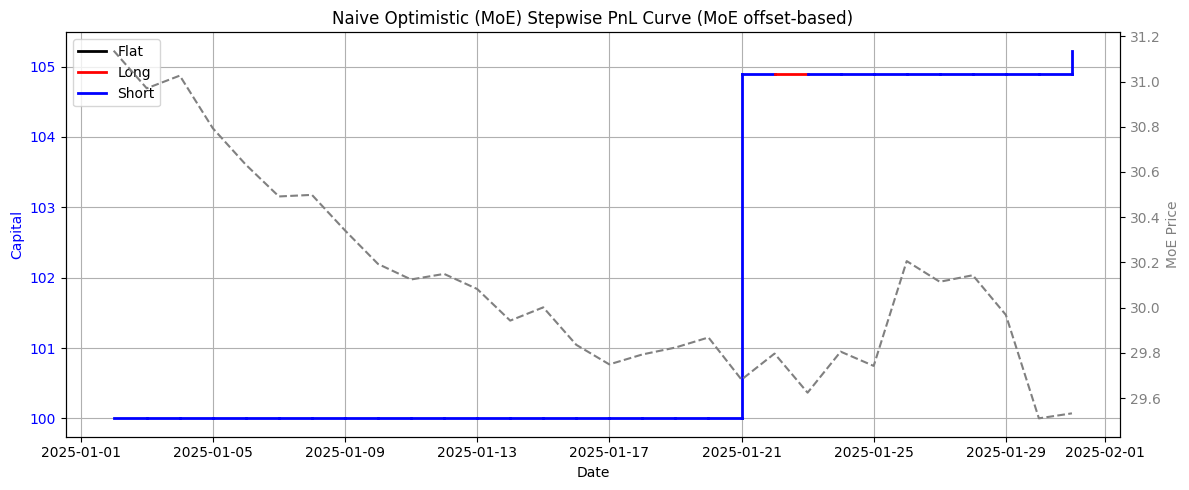

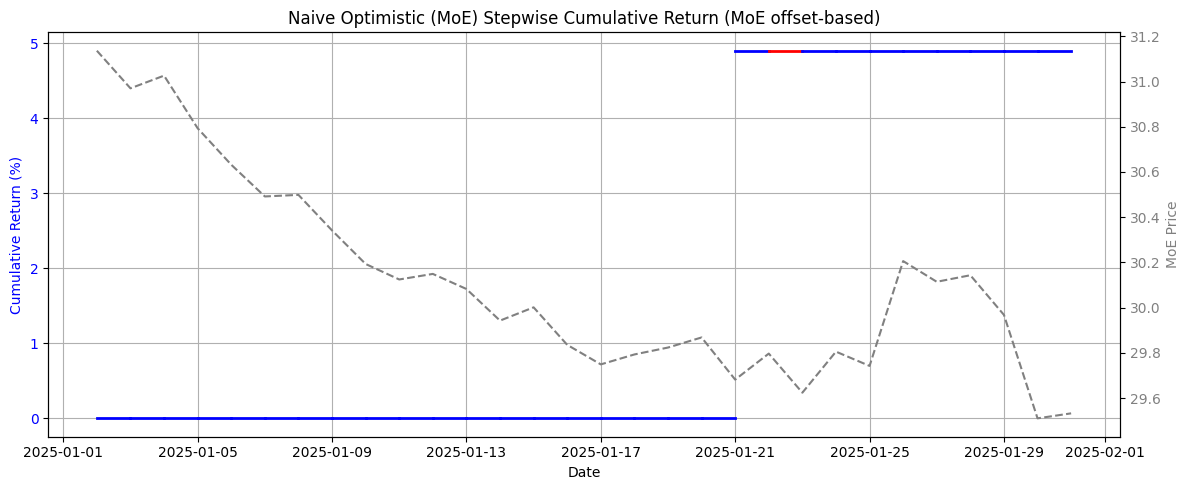


=== MoE Trading Strategies complete! ===



In [17]:
###############################################################################
# A. Polynomial Fitting & Gradient for the Final MoE Curve
###############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error

def format_polynomial(coeffs):
    """
    Convert polynomial coefficients into a readable expression.
    Highest-degree term first, then next, etc.
    """
    terms = []
    degree = len(coeffs) - 1
    for i, c in enumerate(coeffs):
        power = degree - i
        sign = "+" if c >= 0 else ""
        if power > 1:
            terms.append(f"{sign}{c:.3g}*x^{power}")
        elif power == 1:
            terms.append(f"{sign}{c:.3g}*x")
        else:
            terms.append(f"{sign}{c:.3g}")
    expr = "".join(terms).replace("+-", "-")
    return expr.strip("+")

def derivative_expression(coeffs):
    d_coeffs = np.polyder(coeffs)
    return format_polynomial(d_coeffs)

def polynomial_fit_moe_curve(df_moe):
    """
    df_moe must have columns ["ForecastDate", "MOE_Price"].
    We'll rename them to ["Date", "MoE"] and do polynomial fitting from degrees 1..50.
    We'll do a train/validation split (e.g. even vs. odd indices).
    Returns:
      df_poly: the working DataFrame with an added 'mdates_num' column
      best_poly: dict with best-fitting polynomial's degree, coeffs, val_mse
    """
    # 1) Copy and rename
    df_poly = df_moe.copy()
    df_poly = df_poly.rename(columns={"ForecastDate": "Date", "MOE_Price": "MoE"})
    df_poly.dropna(subset=["MoE"], inplace=True)
    df_poly.sort_values("Date", inplace=True)
    df_poly.reset_index(drop=True, inplace=True)

    if df_poly.empty:
        print("No MoE data to fit.")
        return pd.DataFrame(), {}

    # 2) Convert dates to numeric (for np.polyfit)
    df_poly["mdates_num"] = mdates.date2num(df_poly["Date"])

    # 3) Train/Val split: even indices => train, odd => val
    n_pts = len(df_poly)
    indices = np.arange(n_pts)
    train_mask = (indices % 2 == 0)
    val_mask = ~train_mask

    x_train = df_poly.loc[train_mask, "mdates_num"].values
    y_train = df_poly.loc[train_mask, "MoE"].values
    x_val   = df_poly.loc[val_mask, "mdates_num"].values
    y_val   = df_poly.loc[val_mask, "MoE"].values

    def val_mse(coeffs, xv, yv):
        y_pred = np.polyval(coeffs, xv)
        return mean_squared_error(yv, y_pred)

    best_poly = {"degree": None, "coeffs": None, "val_mse": float("inf")}
    deg_candidates = range(1, 51)
    for d in deg_candidates:
        coeffs = np.polyfit(x_train, y_train, d)
        this_mse = val_mse(coeffs, x_val, y_val)
        if this_mse < best_poly["val_mse"]:
            best_poly["degree"] = d
            best_poly["coeffs"] = coeffs
            best_poly["val_mse"] = this_mse

    return df_poly, best_poly

def plot_polynomial_and_derivative(df_poly, best_poly):
    """
    Produce two plots:
      1) The MoE curve + best-fitting polynomial
      2) The polynomial's derivative
    Prints polynomial expressions as well, so you can see them in the console.
    """
    if df_poly.empty or not best_poly:
        print("No polynomial to plot.")
        return

    d = best_poly["degree"]
    coeffs = best_poly["coeffs"]
    mse = best_poly["val_mse"]

    # Print info to console
    expr = format_polynomial(coeffs)
    d_expr = derivative_expression(coeffs)
    print(f"\n=== Best Polynomial Fit for MoE ===")
    print(f"Degree = {d}, Val MSE = {mse:.6f}")
    print(f"Polynomial: y = {expr}")
    print(f"Derivative: dy/dx = {d_expr}\n")

    # 1) Plot polynomial fit
    x_dense = np.linspace(df_poly["mdates_num"].min(), df_poly["mdates_num"].max(), 300)
    y_dense = np.polyval(coeffs, x_dense)
    x_dense_dates = [mdates.num2date(xx) for xx in x_dense]

    plt.figure(figsize=(12, 6))
    plt.scatter(df_poly["Date"], df_poly["MoE"], color="black", marker="o", label="MoE Data")
    plt.plot(x_dense_dates, y_dense, color="red", linewidth=2,
             label=f"MoE Poly (deg={d})")
    plt.xlabel("Date")
    plt.ylabel("Price (MoE)")
    plt.title("MoE Curve vs. Best-Fit Polynomial")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2) Plot derivative
    d_coeffs = np.polyder(coeffs)
    y_deriv = np.polyval(d_coeffs, x_dense)
    plt.figure(figsize=(12, 6))
    plt.plot(x_dense_dates, y_deriv, color="blue", linewidth=2, label="Polynomial Derivative")
    plt.axhline(0, color="black", linestyle="--", linewidth=1, label="Zero Line")
    plt.xlabel("Date")
    plt.ylabel("d(MoE)/dt")
    plt.title("Derivative of MoE Polynomial")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


###############################################################################
# B. Naive Conservative & Naive Optimistic Trading on MoE's Gradient
###############################################################################
def get_moe_signals_from_derivative(df_poly, best_poly):
    """
    df_poly has columns [Date, MoE, mdates_num].
    best_poly => we only need 'coeffs' from it.

    We'll compute daily derivative (gradient) and produce:
     - signals_conservative
     - signals_optimistic

    Since there's only ONE curve (MoE), the difference between
    Naive Conservative vs. Optimistic is minimal (both
    produce identical signals when derivative>0 or <0).
    We return both for completeness.
    """
    if df_poly.empty or not best_poly:
        return df_poly.copy(), None, None

    coeffs = best_poly["coeffs"]
    d_coeffs = np.polyder(coeffs)

    # Evaluate derivative for each row
    df_work = df_poly.copy()
    df_work["MoE_Gradient"] = np.polyval(d_coeffs, df_work["mdates_num"].values)

    signals_conservative = np.zeros(len(df_work), dtype=int)
    signals_optimistic   = np.zeros(len(df_work), dtype=int)

    for i in range(len(df_work)):
        grad = df_work.loc[i, "MoE_Gradient"]
        if grad > 0:
            signals_conservative[i] = 1
            signals_optimistic[i]   = 1
        elif grad < 0:
            signals_conservative[i] = -1
            signals_optimistic[i]   = -1
        else:
            signals_conservative[i] = 0
            signals_optimistic[i]   = 0

    df_work["ConSignal"] = signals_conservative
    df_work["OptSignal"] = signals_optimistic
    return df_work, signals_conservative, signals_optimistic


###############################################################################
# C. Piecewise Offset Trading Simulation
###############################################################################
def get_segments(df_signal, signal_col="Signal"):
    segments = []
    start_idx = 0
    curr_sig = df_signal.loc[start_idx, signal_col]
    for idx in range(1, len(df_signal)):
        if df_signal.loc[idx, signal_col] != curr_sig:
            segments.append((start_idx, idx - 1, curr_sig))
            start_idx = idx
            curr_sig = df_signal.loc[idx, signal_col]
    segments.append((start_idx, len(df_signal) - 1, curr_sig))
    return segments

def piecewise_trading_offset(df_signal):
    """
    Each contiguous segment with same signal >=2 days => realize PnL at segment end.
    1-day segments => ignored.
    """
    segs = get_segments(df_signal, "Signal")
    capital = 100.0
    cap_arr = np.zeros(len(df_signal))
    trade_log = []

    for (start, end, sig) in segs:
        seg_days = end - start + 1
        start_date = df_signal.loc[start, "Date"]
        end_date = df_signal.loc[end, "Date"]

        # propagate capital
        for i in range(start, end + 1):
            cap_arr[i] = capital

        if seg_days < 2:
            # ignore single-day
            trade_log.append({
                "Signal": "Flat(ignored)",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": df_signal.loc[start, "MoE"],
                "ExitPrice": df_signal.loc[end, "MoE"],
                "AbsDiff": 0.0,
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })
            continue

        entry_price = df_signal.loc[start, "MoE"]
        exit_price  = df_signal.loc[end, "MoE"]

        if sig == 1:
            # Long
            final_cap = capital * (exit_price / entry_price)
            seg_ret = (final_cap / capital) - 1.0
            cap_arr[end] = final_cap
            capital = final_cap
            trade_log.append({
                "Signal": "Long",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_price,
                "ExitPrice": exit_price,
                "AbsDiff": abs(exit_price - entry_price),
                "SegmentReturn(%)": seg_ret * 100.0,
                "EndCapital": final_cap
            })
        elif sig == -1:
            # Short
            final_cap = capital * (entry_price / exit_price)
            seg_ret = (final_cap / capital) - 1.0
            cap_arr[end] = final_cap
            capital = final_cap
            trade_log.append({
                "Signal": "Short",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_price,
                "ExitPrice": exit_price,
                "AbsDiff": abs(exit_price - entry_price),
                "SegmentReturn(%)": seg_ret * 100.0,
                "EndCapital": final_cap
            })
        else:
            # Flat
            trade_log.append({
                "Signal": "Flat",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_price,
                "ExitPrice": exit_price,
                "AbsDiff": abs(exit_price - entry_price),
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })

    # forward fill after final segment
    last_cap = capital
    for i in range(len(df_signal)):
        if cap_arr[i] == 0.0:
            cap_arr[i] = last_cap
        else:
            last_cap = cap_arr[i]

    df_signal["Capital"] = cap_arr
    df_signal["Cumulative_PnL"] = df_signal["Capital"] - 100.0
    df_signal["Cumulative_Return"] = (df_signal["Cumulative_PnL"] / 100.0) * 100.0

    return df_signal, trade_log

def reindex_daily(df_signal):
    """
    Reindex to daily frequency, forward-fill columns
    for stepwise plotting.
    """
    df_signal = df_signal.copy()
    df_signal.set_index("Date", inplace=True)
    all_days = pd.date_range(start=df_signal.index.min(), end=df_signal.index.max(), freq="D")
    df_signal = df_signal.reindex(all_days)

    df_signal["MoE"].ffill(inplace=True)
    df_signal["Capital"].ffill(inplace=True)
    df_signal["Cumulative_PnL"].ffill(inplace=True)
    df_signal["Cumulative_Return"].ffill(inplace=True)
    df_signal["Signal"].ffill(inplace=True)

    df_signal.reset_index(inplace=True)
    df_signal.rename(columns={"index": "Date"}, inplace=True)
    return df_signal

###############################################################################
# D. Stepwise Plots + Logs
###############################################################################
def plot_stepwise_pnl_curve(df_signal, trade_log, title=""):
    """
    Stepwise capital curve plot (offset-based) using the "Signal" column.
    The MoE curve is plotted on a second y-axis.
    Everything prints to console so you can review the logs and
    see the final capital, PnL, etc.
    """
    print(f"\n===== {title} Trade Log =====")
    for trd in trade_log:
        print(
            f"{trd['Signal']:5s} | {trd['StartDate'].date()} -> {trd['EndDate'].date()} "
            f"({trd['Days']} days) | "
            f"Entry={trd['EntryPrice']:.2f}, Exit={trd['ExitPrice']:.2f} "
            f"(AbsDiff={trd['AbsDiff']:.2f}) | "
            f"Return={trd['SegmentReturn(%)']:.2f}% | "
            f"EndCap={trd['EndCapital']:.2f}"
        )

    final_cap = df_signal["Capital"].iloc[-1]
    final_pnl = df_signal["Cumulative_PnL"].iloc[-1]
    final_ret = df_signal["Cumulative_Return"].iloc[-1]
    print(f"\n=== Final Results: {title} ===")
    print(f"Final Capital = {final_cap:.2f}, PnL={final_pnl:.2f}, Return={final_ret:.2f}%")

    fig, ax1 = plt.subplots(figsize=(12, 5))
    color_map = {0: "black", 1: "red", -1: "blue"}
    n_rows = len(df_signal)

    for i in range(1, n_rows):
        sig_prev = int(df_signal.loc[i-1, "Signal"])

        # Horizontal
        x_vals_h = [df_signal.loc[i-1, "Date"], df_signal.loc[i, "Date"]]
        y_vals_h = [df_signal.loc[i-1, "Capital"], df_signal.loc[i-1, "Capital"]]
        ax1.plot(x_vals_h, y_vals_h, color=color_map[sig_prev], linewidth=2)

        # Vertical
        x_vals_v = [df_signal.loc[i, "Date"], df_signal.loc[i, "Date"]]
        y_vals_v = [df_signal.loc[i-1, "Capital"], df_signal.loc[i, "Capital"]]
        ax1.plot(x_vals_v, y_vals_v, color=color_map[sig_prev], linewidth=2)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Capital", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(True)

    # second y-axis => MoE curve
    ax2 = ax1.twinx()
    ax2.plot(df_signal["Date"], df_signal["MoE"], color="gray", linestyle="--", linewidth=1.5)
    ax2.set_ylabel("MoE Price", color="gray")
    ax2.tick_params(axis="y", labelcolor="gray")

    legend_elems = [
        Line2D([0], [0], color='black', lw=2, label='Flat'),
        Line2D([0], [0], color='red',   lw=2, label='Long'),
        Line2D([0], [0], color='blue',  lw=2, label='Short')
    ]
    ax1.legend(handles=legend_elems, loc="upper left")
    ax1.set_title(f"{title} Stepwise PnL Curve (MoE offset-based)")
    plt.tight_layout()
    plt.show()

def plot_stepwise_return_curve(df_signal, title=""):
    """
    Similar stepwise logic, but plots Cumulative_Return (%) vs. Date.
    The user can print out the final capital from the logs and
    see how the daily return evolves. 
    """
    fig, ax1 = plt.subplots(figsize=(12, 5))
    color_map = {0: "black", 1: "red", -1: "blue"}
    n_rows = len(df_signal)

    for i in range(1, n_rows):
        sig_prev = int(df_signal.loc[i-1, "Signal"])

        # Horizontal
        x_h = [df_signal.loc[i-1, "Date"], df_signal.loc[i, "Date"]]
        y_h = [df_signal.loc[i-1, "Cumulative_Return"], df_signal.loc[i-1, "Cumulative_Return"]]
        ax1.plot(x_h, y_h, color=color_map[sig_prev], linewidth=2)

        # Vertical
        x_v = [df_signal.loc[i, "Date"], df_signal.loc[i, "Date"]]
        y_v = [df_signal.loc[i-1, "Cumulative_Return"], df_signal.loc[i-1, "Cumulative_Return"]]
        ax1.plot(x_v, y_v, color=color_map[sig_prev], linewidth=2)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Cumulative Return (%)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(df_signal["Date"], df_signal["MoE"], color="gray", linestyle="--", linewidth=1.5)
    ax2.set_ylabel("MoE Price", color="gray")
    ax2.tick_params(axis='y', labelcolor="gray")

    ax1.set_title(f"{title} Stepwise Cumulative Return (MoE offset-based)")
    plt.tight_layout()
    plt.show()


###############################################################################
# E. Putting It All Together with Naive Conservative & Optimistic
###############################################################################
def run_moe_trading_strategies(df_moe):
    """
    1) Polynomial fit & derivative
    2) Generate signals for naive conservative + naive optimistic
    3) Run piecewise trading sim
    4) Print out all information and draw the diagrams from the output
       (trade logs, final capital, stepwise capital curve, etc.)
    """
    # A. Polynomial fit
    df_poly, best_poly = polynomial_fit_moe_curve(df_moe)
    if df_poly.empty or not best_poly:
        print("No MoE polynomial model found => skip.")
        return

    # B. Plots & Info
    plot_polynomial_and_derivative(df_poly, best_poly)

    # C. Derivative-based signals
    df_signals, con_sigs, opt_sigs = get_moe_signals_from_derivative(df_poly, best_poly)
    if df_signals.empty:
        print("No MoE signals => skip.")
        return

    # D. Naive Conservative
    df_con = df_signals.copy()
    df_con.rename(columns={"ConSignal": "Signal"}, inplace=True)
    df_con_sim, trade_log_con = piecewise_trading_offset(df_con)
    df_con_sim = reindex_daily(df_con_sim)

    plot_stepwise_pnl_curve(df_con_sim, trade_log_con, title="Naive Conservative (MoE)")
    plot_stepwise_return_curve(df_con_sim, title="Naive Conservative (MoE)")

    # E. Naive Optimistic
    df_opt = df_signals.copy()
    df_opt.rename(columns={"OptSignal": "Signal"}, inplace=True)
    df_opt_sim, trade_log_opt = piecewise_trading_offset(df_opt)
    df_opt_sim = reindex_daily(df_opt_sim)

    plot_stepwise_pnl_curve(df_opt_sim, trade_log_opt, title="Naive Optimistic (MoE)")
    plot_stepwise_return_curve(df_opt_sim, title="Naive Optimistic (MoE)")

    print("\n=== MoE Trading Strategies complete! ===\n")


run_moe_trading_strategies(df_moe)

